<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model Interpretation for Pretrained Binary MNIST Model using KernelSHAP

This notebook demonstrates how to apply KernelSHAP method on pretrained binary MNIST model using a hand-written digit image. It visualizes the relevance attributions for each pixel/super-pixel by displaying them on the image. <br>

SHapley Additive exPlanations, in short, SHAP, is a model-agnostic explainable AI approach which is used to decrypt the black-box models through estimating the Shapley values.<br>

KernelSHAP is a variant of SHAP. It is a method that uses the LIME framework to compute Shapley Values.<br>

More details about this method can be found in the paper https://arxiv.org/abs/1705.07874.

### Colab Setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  # install dianna
  !python3 -m pip install dianna[notebooks]
  
  # download data used in this demo
  import os 
  base_url = 'https://raw.githubusercontent.com/dianna-ai/dianna/main/dianna/'
  paths_to_download = ['./data/binary-mnist.npz', './models/mnist_model_tf.onnx']
  for path in paths_to_download:
      !wget {base_url + path} -P {os.path.dirname(path)}

### Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import numpy as np
import dianna
import onnx
from onnx_tf.backend import prepare
import matplotlib.pyplot as plt
from pathlib import Path

#### 1 - Loading the model and the dataset
Loads pretrained binary MNIST model and the image to be explained.

Load saved binary MNIST data.

In [3]:
# load dataset
data = np.load(Path('..','..','..','dianna','data', 'binary-mnist.npz'))
# load testing data and the related labels
X_test = data['X_test'].astype(np.float32).reshape([-1, 28, 28, 1]) / 255
y_test = data['y_test']

Load the pretrained binary MNIST model.

In [4]:
# Load saved onnx model
onnx_model_path = Path('..','..','..','dianna','models', 'mnist_model_tf.onnx')
onnx_model = onnx.load(onnx_model_path)
# get the output node
output_node = prepare(onnx_model, gen_tensor_dict=True).outputs[0]

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-09 11:29:59.327587: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-09 11:29:59.327685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Print class and image of a single instance in the test data for preview.

2023-05-09 11:30:01.721074: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-09 11:30:01.721134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


The predicted class is: digit 0


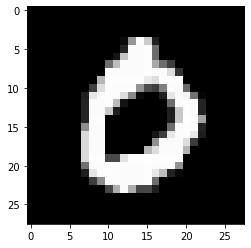

In [5]:
# class name
class_name = ['digit 0', 'digit 1']
# instance index
i_instance = 1
# select instance for testing
test_sample = X_test[i_instance].copy().astype(np.float32)
# model predictions with added batch axis to test sample
predictions = prepare(onnx_model).run(test_sample[None, ...])[f'{output_node}']
pred_class = class_name[np.argmax(predictions)]
print("The predicted class is:", pred_class)
plt.imshow(X_test[i_instance][:,:,0], cmap='gray')  # 0 for channel

#### 2 - Compute Shapley values and visualize the relevance attributions
Approximate Shapley values using KernelSHAP and visualize the relevance attributions on the image. <br>

KernelSHAP approximate Shapley values in the LIME framework.
The user need to specified the number of times to re-evaluate the model when explaining each prediction (`nsamples`). A binary mask need to be applied to the image to represent if an image region is hidden. It requires the background color for the masked image, which can be specified by `background`.<br>

Performing KernelSHAP on each pixel is inefficient. It is always a good practice to segment the input image and perform computations on the obtained superpixels. This requires the user to specify some keyword arguments related to the segmentation, like the (approximate) number of labels in the segmented output image (`n_segments`), and width of Gaussian smoothing kernel for pre-processing for each dimension of the image (`sigma`).

In [6]:
# use KernelSHAP to explain the network's predictions
shap_values, segments_slic = dianna.explain_image(onnx_model_path, test_sample, labels=[1],
                                                  method="KernelSHAP", nsamples=1000,
                                                  background=0, n_segments=200, sigma=0,
                                                  axis_labels=('height','width','channels'))

2023-05-09 11:30:03.734986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
  0%|          | 0/1 [00:00<?, ?it/s]2023-05-09 11:30:03.991305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-09 11:30:04.602026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Define a function to fill each pixel with shap values based on the segmentation. <br>
This function is used to make plots.

In [7]:
# fill each pixel with SHAP values 
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

Visualize Shapley scores on the images.

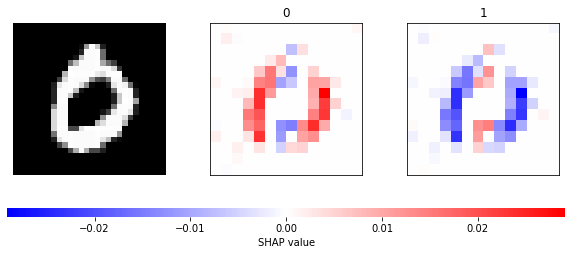

In [8]:
# get the index of predictions
top_preds = np.argsort(-predictions)
inds = top_preds[0]
# Visualize the explanations
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
axes[0].imshow(test_sample, cmap='gray')
axes[0].axis('off')
# get the range for color bar
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
# plot the test image and the attributions on the image for each class
for i in range(2):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(str(inds[i]))
    axes[i+1].imshow(test_sample, alpha=0.15)
    im = axes[i+1].imshow(m, vmin=-max_val, vmax=max_val, cmap='bwr')
    #axes[i+1].axis('off')
    axes[i+1].set_xticks([])
    axes[i+1].set_yticks([])
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

#### 3 - Conclusions
The Shapley scores are estimated using KernelSHAP for models used to categorize the binary MNIST. The example here shows that the KernelSHAP method evaluates the importance of each segmentation/super pixel to the classification and the results are reasonable compared to the human visual preception of the chosen testing hand-written digit image.
